## Load Libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import scipy.io
from scipy import stats
from scipy.io import loadmat
from scipy.optimize import minimize
import hdf5plugin
import multiprocessing
import os
import time
import sys
sys.path.append('/sdf/scratch/lcls/ds/cxi/cxily5921/scratch/aansari2/cxily59/reborn')
import reborn
from reborn.external import denss
from reborn.external.denss import saxstats
from reborn.detector import load_pad_geometry_list
from reborn.source import load_beam

import pickle


### Some settings

In [2]:
# Set the default font family to Nimbus Roman
plt.rcParams['font.family'] = 'Nimbus Roman'
plt.rcParams['font.size'] = 18  # Increase the font size
plt.rcParams['axes.titlesize'] = 18  # Title font size
plt.rcParams['axes.labelsize'] = 18  # X and Y label font size
plt.rcParams['xtick.labelsize'] = 18  # X tick label font size
plt.rcParams['ytick.labelsize'] = 18  # Y tick label font size
plt.rcParams['legend.fontsize'] = 18  # Legend font size

# Load the .mat files
data = loadmat('2qsp.mat')
q_mags = data['q_mags']
profile = data['profile']
pixelcount = loadmat('accum_sapf.mat')['accum_sapf']
pixelcount[pixelcount > 4e4] = 0

scale = (75e-6 / 0.57) ** 2
maxr = 6e9
num_bins = 500
rbins = np.linspace(0, maxr, num_bins + 1)
rad = 0.5 * (rbins[1:] + rbins[:-1])

## Thresholding Class
* Eliminate 2 sigma outliers of photonEV
* Eliminate dull pulse Energy
* eliminate bright frames
* compute uncertainty

In [3]:
class Result:
    pass

def extractDataFromRun(runno, highQThresh, fullQThresh):
    # This code extracts SAXS data and uses it to throw out all the frames
    # import main data
    filename = '/sdf/data/lcls/ds/cxi/cxily5921/scratch/data/v4/h5dat/{:04d}/{:04d}.h5'.format(runno, runno)
    file_buffer = h5py.File(filename, 'r')
    dataspace = file_buffer['/data/calib'].shape
    print(dataspace)
    result = Result()
    result.runno = runno

    # import saxs data
    file_path_sample = '/sdf/scratch/lcls/ds/cxi/cxily5921/scratch/data/rkirian/SAXSPatterns/{:04d}.h5'.format(runno)
    with h5py.File(file_path_sample, 'r') as f:
        dataset_sample = np.array(f['/SAXS']).T
        print('Shape of the SAXS dataset:', dataset_sample.shape)
    diode = np.array(file_buffer['diode'])
    photonEV = np.array(file_buffer['photon_energy'])
    
    # make histograms
    outerQ = np.mean(dataset_sample[250:,:], axis=0)
    fullQ = np.mean(dataset_sample, axis=0)
    # Compute the bin edges based on the combined data
    combined_data = np.concatenate((outerQ, fullQ))
    bins = np.linspace(combined_data.min(), 1e6, 300)
    plt.figure(figsize=(10, 6))
    plt.hist(outerQ, bins=bins, color='blue', alpha=0.7, label='outerQ', density=True)
    plt.hist(fullQ, bins=bins, color='green', alpha=0.7, label='fullQ', density=True)
    plt.title('Histograms of outerQ and fullQ')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
    plt.hist(photonEV, bins=(7000+np.linspace(-1,1,100)*1e2), color='blue', alpha=0.7, label='Photon EV', density=True)
    plt.show()
    plt.hist(diode, bins=100, color='blue', alpha=0.7, label='Photon Energy', density=True)
    plt.show()
    result.meanPhotonEV = np.mean(photonEV[photonEV!=0])
    result.stdPhotonEV = np.std(photonEV[photonEV!=0])
    print("Mean photon EV:", result.meanPhotonEV,'+-',result.stdPhotonEV)

    # Eliminate 2 sigma outliers of photonEV
    indices_sample = (photonEV > (result.meanPhotonEV - 2*result.stdPhotonEV)) & (photonEV < (result.meanPhotonEV + 2*result.stdPhotonEV))
    # Eliminate dull pulse Energy
    indices_sample = indices_sample & (diode>10000)
    # eliminate bright frames
    indices_sample = indices_sample & (np.mean(dataset_sample[250:,:], axis=0) < highQThresh) & (np.mean(dataset_sample, axis=0) < fullQThresh)
    indices_sample = indices_sample & (np.mean(dataset_sample, axis=0)!=0)
    result.sampleSAXS = np.mean(dataset_sample[:,indices_sample], axis=1) * scale
    # brightness 
    result.averageBrightness = np.sum(pixelcount.T*dataset_sample[:,indices_sample], axis=0)/np.sum(pixelcount)*scale
    result.sampFrameCount = np.sum(indices_sample)
    result.diode = diode[indices_sample]

    # compute uncertainty
    samplePhotonsPerBin = result.sampleSAXS * pixelcount * result.sampFrameCount
    sampleRelError = np.sqrt(samplePhotonsPerBin) / samplePhotonsPerBin
    result.sampleSAXSError = sampleRelError.flatten() * result.sampleSAXS.flatten()
    result.indices_sample = indices_sample
    return result

def process_chunk(chunk, filename):
    with h5py.File(filename, 'r') as file_buffer:
        data = np.zeros(file_buffer['/data/calib'].shape[1])
        for index in chunk:
            startData = file_buffer['/data/calib'][index, :]
            thresholdMask = (startData == 0)
            fixedData = (startData - offset)/gain
            fixedData[thresholdMask] = 0
            fixedData[fixedData < 0.3] = 0
            data += fixedData
    return data

# Function to divide indices into chunks
def chunk_indices(indices, num_chunks):
    chunks = np.array_split(indices, num_chunks)
    return chunks

def averageData(buffer):
    filename = f'/sdf/data/lcls/ds/cxi/cxily5921/scratch/data/v4/h5dat/{buffer.runno:04d}/{buffer.runno:04d}.h5'
    start_time = time.time()

    # Open the HDF5 file
    with h5py.File(filename, 'r') as file_buffer:
        dataspace = file_buffer['/data/calib'].shape
        true_indices = buffer.indices_sample
        where_true = np.where(true_indices)
        where_true = where_true[0]
        dataspace = np.array(dataspace)
        print('data shape [no of frames, no of pixels]:', dataspace)
        print(true_indices.shape)

        # Number of available CPU cores
        num_cores = os.cpu_count()
        print(f"Number of CPU cores available: {num_cores}")

        # Split indices into chunks for parallel processing
        chunks = chunk_indices(where_true, num_cores)

        # Create a pool of workers
        with multiprocessing.Pool(processes=num_cores) as pool:
            results = pool.starmap(process_chunk, [(chunk, filename) for chunk in chunks])

        # Aggregate the results
        averagedData = np.sum(results, axis=0) / len(where_true)
        print('Final averaged data:', averagedData)

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return averagedData

## Following code does gain adjustment

In [4]:
# Load the stats variable from the file
with open('cstats.pkl', 'rb') as file:
    cstats = pickle.load(file)

print(cstats['histogram'])

def find_argmax_in_range(cstats, start_col, end_col):
    """
    Find indices of the maximum values within a specified column range on axis=1.

    Parameters:
    - stats: 2D numpy array
    - start_col: starting column index (inclusive)
    - end_col: ending column index (inclusive)

    Returns:
    - argmax_indices_in_original: 1D numpy array with indices of the maximum values
    """
    stats = cstats['histogram']

    # Find and adjust indices in one line
    chunk = stats[:, start_col:end_col + 1]
    local_max = np.argmax(chunk, axis = 1)
    left = local_max - 1
    right = local_max + 1
    left[local_max==0] += 1
    right[local_max==0] += 1
    local_max[local_max==0] += 1
    right[local_max==chunk.shape[1]-1] -= 1
    left[local_max==chunk.shape[1]-1] -= 1
    local_max[local_max==chunk.shape[1]-1] -= 1
    center_max = chunk[np.arange(chunk.shape[0]),local_max]
    left_max = chunk[np.arange(chunk.shape[0]),left]
    right_max = chunk[np.arange(chunk.shape[0]),right]
    slope = (right_max-left_max)/2
    curve = right_max-2*center_max+left_max
    x = -np.divide(slope,(2*curve))
    x[np.isnan(x)] = 0
    x[np.isinf(x)] = 0

    ADUs = np.linspace(cstats['histogram_params']['bin_min'], 
                       cstats['histogram_params']['bin_max'], 
                       cstats['histogram_params']['n_bins'])
    #ADUs = 0.5*(ADUs[1:]+ADUs[:-1])
    ADUpeak = np.interp(start_col + local_max + x, np.arange(stats.shape[1]), ADUs )
    return ADUpeak
offset = find_argmax_in_range(cstats, 17, 23)
gain = find_argmax_in_range(cstats, 40, 60)
print('ZeroPeak',np.nanmean(offset), '+-', np.nanstd(offset))
print('OnePhotonPeak', np.nanmean(gain),  '+-', np.nanstd(gain))

[[    0     0     0 ...    17    15 53965]
 [    0     0     0 ...     9     7 53813]
 [    0     0     0 ...     1    11 53778]
 ...
 [    0     0     0 ...     4     2 53697]
 [    0     0     0 ...     7     2 53696]
 [    0     0     0 ...     7     5 53748]]


/lscratch/aansari2/tmp/ipykernel_3597547/169477853.py:37: RuntimeWarning: divide by zero encountered in divide
  x = -np.divide(slope,(2*curve))
/lscratch/aansari2/tmp/ipykernel_3597547/169477853.py:37: RuntimeWarning: invalid value encountered in divide
  x = -np.divide(slope,(2*curve))


ZeroPeak -0.1749057087971429 +- 0.009178805284522137
OnePhotonPeak 6.710466453060344 +- 0.37565337884837074


## Averaging selected frames
This code will average all non-anamolous frames. The `averageData` subroutine is expected to take about 5 min to run

beam = beam_vec: [0. 0. 1.]
polarization_vec: [0. 1. 0.]
photon_energy: 1.132143158921946e-15
photon_number_fluence: 1.124627689264644e+24

(35763, 4194304)
Shape of the SAXS dataset: (500, 35763)


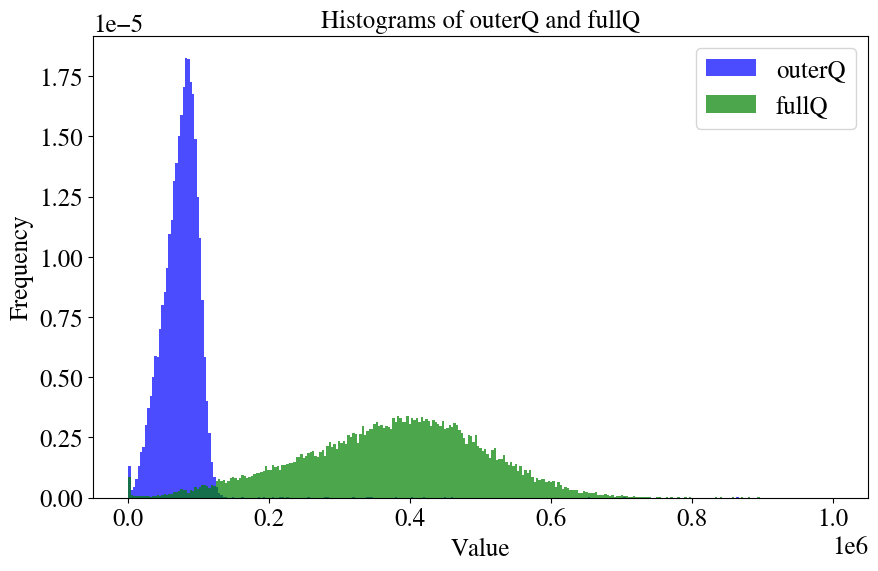

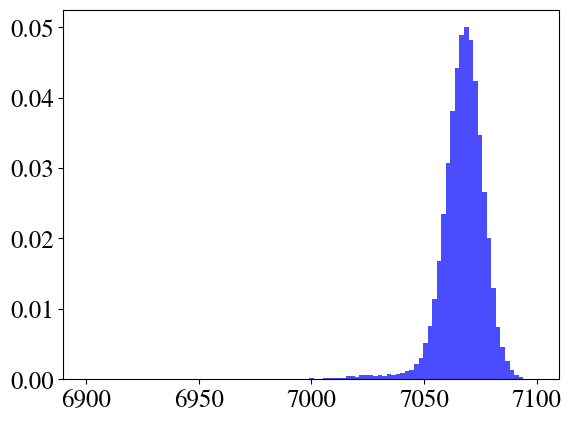

Mean photon EV: 7067.047 +- 10.06232
data shape [no of frames, no of pixels]: [  35763 4194304]
(35763,)
Number of CPU cores available: 40


/lscratch/aansari2/tmp/ipykernel_3597547/2731054288.py:59: RuntimeWarning: invalid value encountered in divide
  sampleRelError = np.sqrt(samplePhotonsPerBin) / samplePhotonsPerBin


Final averaged data: [0.00430356 0.00368095 0.00293728 ... 0.00254926 0.00373835 0.00417189]
Elapsed time: 183.70 seconds
(35929, 4194304)
Shape of the SAXS dataset: (500, 35929)


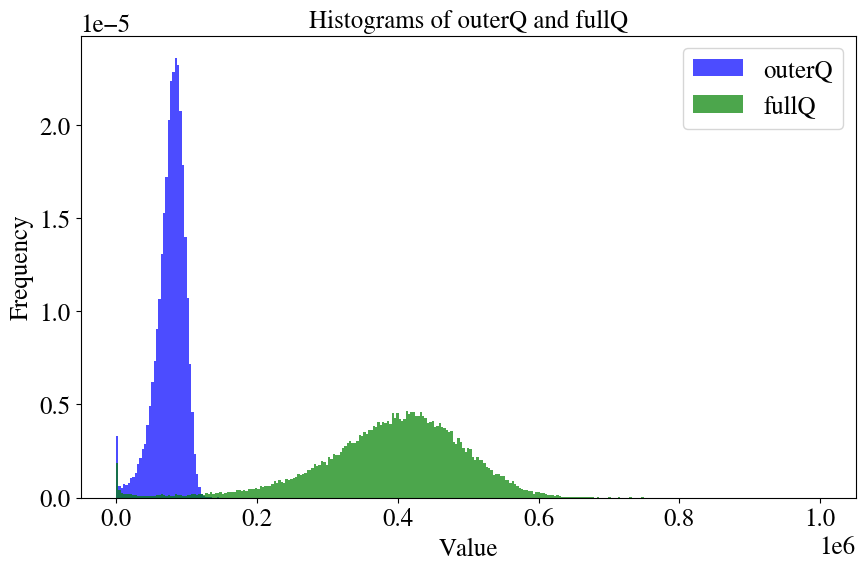

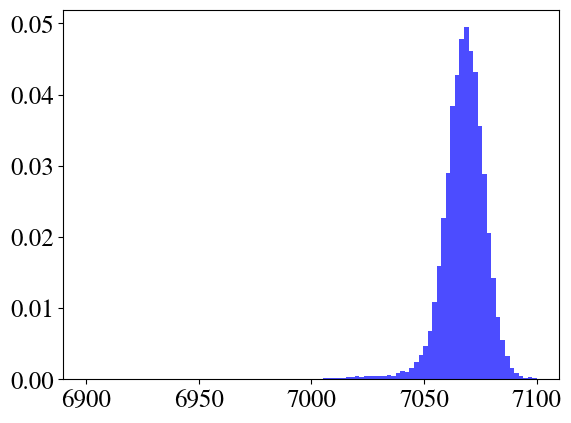

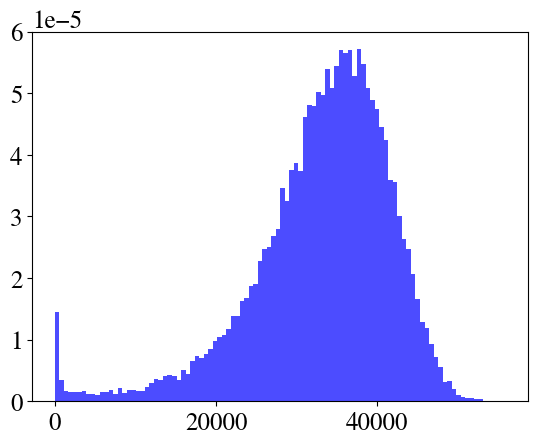

Mean photon EV: 7066.2554 +- 28.973137
data shape [no of frames, no of pixels]: [  35929 4194304]
(35929,)
Number of CPU cores available: 40
Final averaged data: [0.00523096 0.0038786  0.00357008 ... 0.00242767 0.00419044 0.00466799]
Elapsed time: 181.35 seconds
(74784, 4194304)
Shape of the SAXS dataset: (500, 74784)


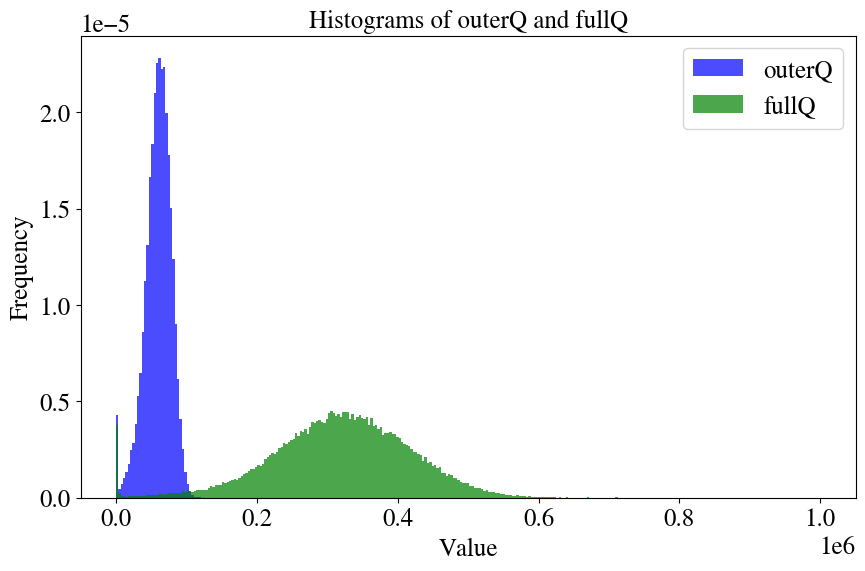

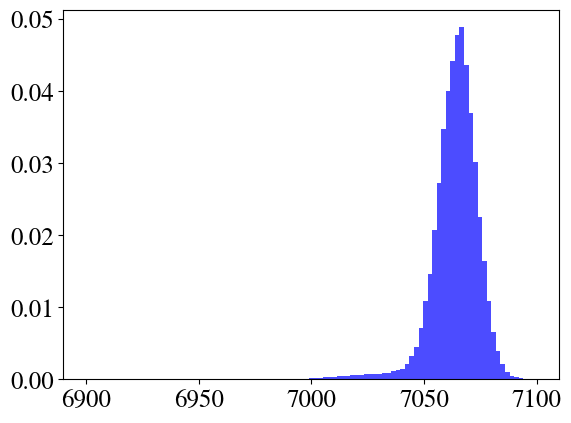

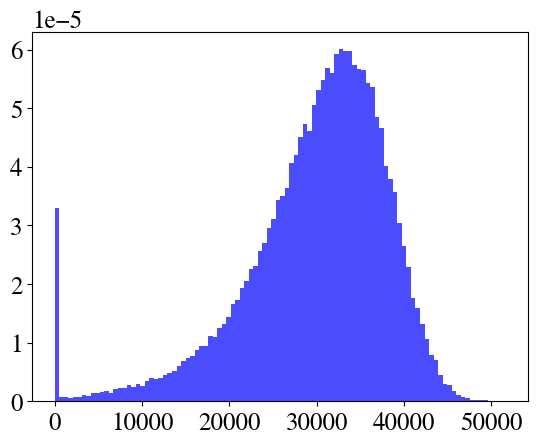

Mean photon EV: 7063.626 +- 11.305164
data shape [no of frames, no of pixels]: [  74784 4194304]
(74784,)
Number of CPU cores available: 40
Final averaged data: [0.00394996 0.00368006 0.00232539 ... 0.00272683 0.00265831 0.00385591]
Elapsed time: 332.88 seconds


In [5]:
thresholds = [[0.8e5,0.8e5,0.6e5],[6e5,6e5,4e5]]
runNumbers = [147, 152, 159]

pads = load_pad_geometry_list('../../../../geometry/current.json') #geometry
beam = load_beam('../../../../geometry/beam.json') # beam
print("beam =", beam)
qvs_data = pads.q_vecs(beam=beam) # q coordinates
averagedData = np.zeros((3,qvs_data.shape[0]))
buffers = []
for i in range(len(runNumbers)):
    runno = runNumbers[i]
    buffer = extractDataFromRun(runno, thresholds[0][i], thresholds[1][i])
    buffers.append(buffer)
    averagedData[i] = averageData(buffer)
    

    


Size of mask:  (2878709,)


/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:85: RuntimeWarning: divide by zero encountered in reciprocal
  SAXSRelError[i] = np.sqrt(np.nansum(totalPhotons,axis = 1))**-1
/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:88: RuntimeWarning: invalid value encountered in divide
  average_matrix[i] /= count_matrix


Size of mask:  (2736316,)


/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:85: RuntimeWarning: divide by zero encountered in reciprocal
  SAXSRelError[i] = np.sqrt(np.nansum(totalPhotons,axis = 1))**-1
/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:88: RuntimeWarning: invalid value encountered in divide
  average_matrix[i] /= count_matrix


Size of mask:  (3250681,)


/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:85: RuntimeWarning: divide by zero encountered in reciprocal
  SAXSRelError[i] = np.sqrt(np.nansum(totalPhotons,axis = 1))**-1
/lscratch/aansari2/tmp/ipykernel_3597547/3701114891.py:88: RuntimeWarning: invalid value encountered in divide
  average_matrix[i] /= count_matrix


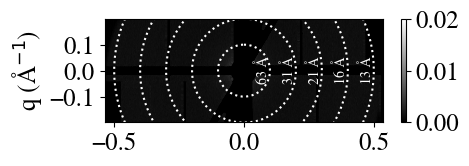

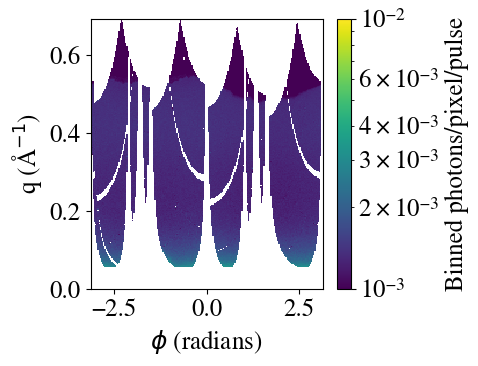

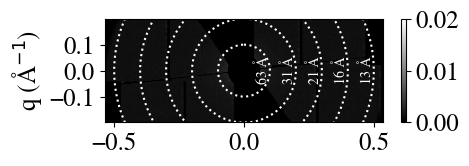

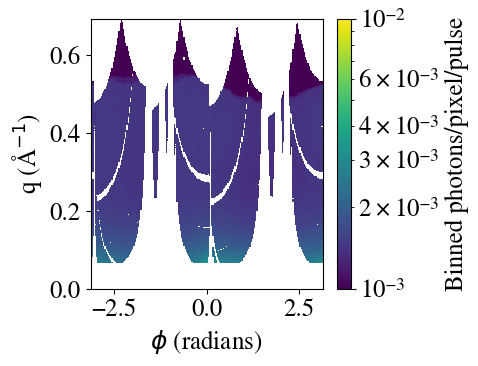

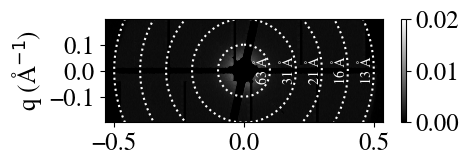

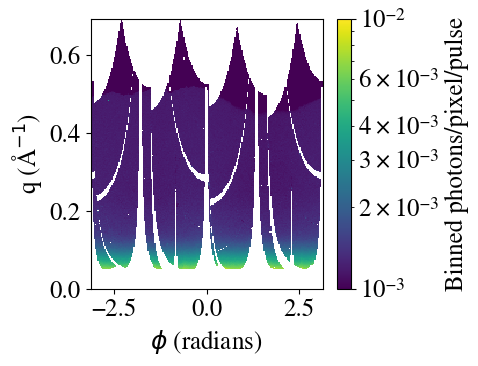

In [7]:
# Correction factor
solidAngles = pads.solid_angles();
polarizationFactors = pads.polarization_factors(beam=beam)

# Define the number of bins for r and theta
M = 250
N = 200
average_matrix = np.zeros((3, M, N))
SAXSRelError = np.zeros((3,M))
for i in range(len(runNumbers)):
    # Pixel Masking
    maskdir = "../../../../geometry/"
    # Removes hot pixels + dead pixels + edge pixels
    mask = reborn.detector.load_pad_masks([
        maskdir + "edge_mask_3_pixels.mask", 
        maskdir + "mask_r0174_dead_pixels_maybe.mask", 
        maskdir + "mask_r0174_hot_pixels_maybe.mask",
        maskdir + "mask_gainThreshold.mask",
        maskdir + "mask_offsetThreshold.mask",
        maskdir + f'mask_r{runNumbers[i]:04d}_streaks.mask'
    ])
    mask = pads.concat_data(mask) # ravel data consistently
    mask = mask.astype(bool) # convert int64 to boolean
    mask = np.where(mask)
    mask = np.array(mask)[0,:]
    print("Size of mask: ", mask.shape)

    #eliminatePixels
    qvs_data_masked = qvs_data[mask,:]

    data_masked = averagedData[i,mask]/(polarizationFactors[mask]*solidAngles[mask]/(75e-6/.577)**2)

    # Create a figure with a larger size
    plt.figure(figsize=(5, 2))

    # Create the scatter plot with a gray colormap based on averagedData
    plt.scatter(qvs_data_masked[::10, 0]*1e-10, qvs_data_masked[::10, 1]*1e-10, c=data_masked[::10], cmap='gray', s=.5)  # s=1 sets the marker size smaller
    t = np.linspace(0,2*np.pi,1000)
    rq = np.linspace(1e9,5e9,5)*1e-10
    t = t[:, np.newaxis]
    plt.plot(rq*np.sin(t),rq*np.cos(t),'w:')
    for j in range(5):
        plt.text(rq[j]*np.cos(t[0]), -rq[j]*np.sin(t[0]), f'{2*np.pi/rq[j]:.0f} Å', color='w', ha='right', va='center', fontsize=10, rotation=90)
    # Set plot axis background to black
    plt.gca().set_facecolor('black')
    plt.clim(0, 0.02)
    plt.axis('equal')

    plt.axis(np.array([-4,4,-1,1])*.1)
    # Set axis labels
    #plt.xlabel('q (Å$^{-1}$)')
    plt.ylabel('q (Å$^{-1}$)')

    # Add a color bar
    plt.colorbar()
    plt.tight_layout()

    plt.savefig(f'results/frame{i}.pdf', format='pdf', dpi=100);
    # Calculate r and theta
    r = np.sqrt(qvs_data_masked[:, 0]**2 + qvs_data_masked[:, 1]**2)
    theta = np.arctan2(qvs_data_masked[:, 1], qvs_data_masked[:, 0])
    


    # Define bins for r and theta
    maxr = np.max(r)
    rbins = np.linspace(0, maxr, M+1)
    tbins = np.linspace(-np.pi, np.pi, N+1)

    # Digitize r and theta to find bin indices
    rindex = np.digitize(r, rbins[:-1]) - 1
    tindex = np.digitize(theta, tbins[:-1]) - 1

    count_matrix = np.zeros((M, N))

    # Use np.add.at to sum the averagedData values into the corresponding bins
    np.add.at(average_matrix[i], (rindex, tindex), data_masked)
    np.add.at(count_matrix, (rindex, tindex), 1)

    # Avoid division by zero by setting zero counts to one temporarily
    #count_matrix[count_matrix == 0] = 1

    #count total photons
    totalPhotons = buffers[i].sampFrameCount*average_matrix[i]
    SAXSRelError[i] = np.sqrt(np.nansum(totalPhotons,axis = 1))**-1
    
    # Calculate the average
    average_matrix[i] /= count_matrix
    
    # Calculate the center points of the bins
    rcenter = 0.5 * (rbins[1:] + rbins[:-1])
    tcenter = 0.5 * (tbins[1:] + tbins[:-1])

    # Create a meshgrid for plotting
    Rcenter, Tcenter = np.meshgrid(rcenter, tcenter)

    # Plot the average_matrix as a function of rcenter and tcenter
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(Tcenter, Rcenter*1e-10, average_matrix[i].T, shading='auto', cmap='viridis',norm=LogNorm())
    plt.clim([1e-3, 1e-2])
    plt.colorbar(label='Binned photons/pixel/pulse')
    plt.xlabel('$\phi$ (radians)')
    plt.ylabel('q (Å$^{-1}$)')
    plt.tight_layout()
    plt.savefig(f'results/bin{i}.pdf', format='pdf')



/lscratch/aansari2/tmp/ipykernel_3597547/680465636.py:12: RuntimeWarning: Mean of empty slice
  plt.plot(rcenter/1e10, np.nanmean(average_matrix[i],axis=1), label=runLabels[i])


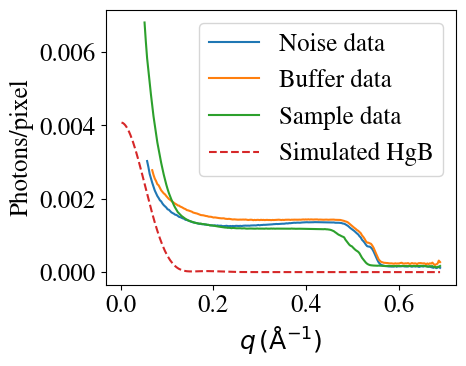

In [9]:
runLabels = ["Noise data", "Buffer data", "Sample data","Simulated Vapour","Simulated HgB"]
from scipy.interpolate import interp1d
def importAndInterpolate(gasname):
    heliumData = np.genfromtxt(gasname, delimiter=',', skip_header=1)
    interp_function = interp1d(heliumData[:,0]*1e10,heliumData[:,1]*scale, kind='linear', fill_value='extrapolate')
    heliumProfile = interp_function(rcenter)
    return heliumProfile

plt.figure(figsize=(5, 4))

for i in range(len(runNumbers)):
    plt.plot(rcenter/1e10, np.nanmean(average_matrix[i],axis=1), label=runLabels[i])
gasProfile = importAndInterpolate('WaterVapourProfile.csv')
#plt.plot(rcenter/1e10, gasProfile, '--',label=runLabels[3])
# Load the .mat files
data = loadmat('2qsp.mat')
q_mags = data['q_mags']
profile = data['profile']
simSAXS = np.interp(rcenter, q_mags.ravel(), profile.ravel() / 400 * scale)
plt.plot(rcenter/1e10, simSAXS, '--',label=runLabels[4])

plt.legend()
plt.xlabel(r'$q \, (\mathrm{\AA}^{-1})$')
plt.ylabel('Photons/pixel')

plt.tight_layout()
plt.savefig(f'results/allData.pdf', format='pdf')

/lscratch/aansari2/tmp/ipykernel_3597547/1480658780.py:1: RuntimeWarning: Mean of empty slice
  gasn = np.nanmean(average_matrix[0],axis=1)
/lscratch/aansari2/tmp/ipykernel_3597547/1480658780.py:2: RuntimeWarning: Mean of empty slice
  buff = np.nanmean(average_matrix[1],axis=1)
/lscratch/aansari2/tmp/ipykernel_3597547/1480658780.py:3: RuntimeWarning: Mean of empty slice
  samp = np.nanmean(average_matrix[2],axis=1)


[-0.67805409 -0.16482603  0.          0.         -1.38030906]


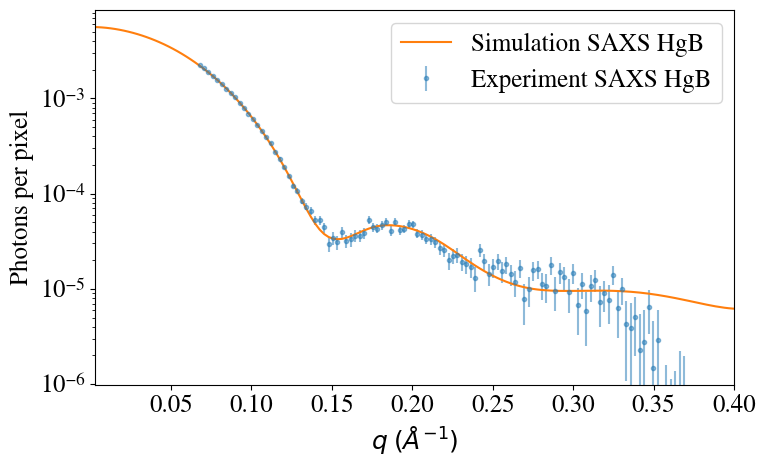

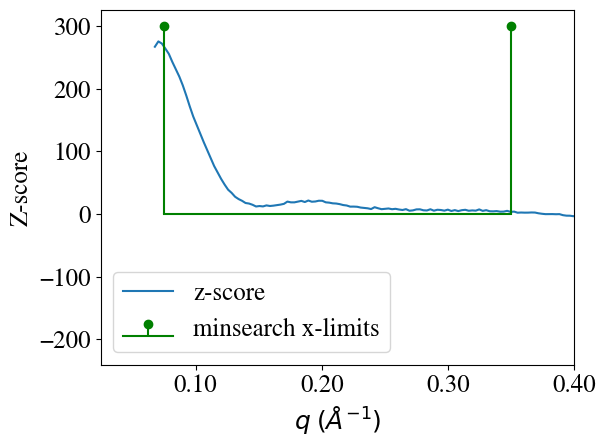

In [10]:
gasn = np.nanmean(average_matrix[0],axis=1)
buff = np.nanmean(average_matrix[1],axis=1)
samp = np.nanmean(average_matrix[2],axis=1)

# uncertainty
gainRelUncertainty = 0.00
gasn_e = gasn*(SAXSRelError[0]+gainRelUncertainty)
buff_e = buff*(SAXSRelError[1]+gainRelUncertainty)
samp_e = samp*(SAXSRelError[2]+gainRelUncertainty)

rad = rcenter
# Minimization
window = [.75e9, 3.5e9]
conds = (rcenter > window[0]) & (rcenter < window[1])
#initial_guess = [0.5661,   0.0001,   1, 0.1, 0.8713]
initial_guess = [1,   1,   1, 1, 1]

def objective(x): 
    return np.mean((samp[conds] + buff[conds] * x[0] + gasn[conds]*x[1] + gasProfile[conds]*x[2] + x[3] + x[4] * simSAXS[conds]) ** 2)
#                                                                                          buffer        gas        gas-sim       const      protien sim
opt_params = minimize(objective, initial_guess,  method='Trust-constr', tol=1e-26, bounds=[(None, 0), (None, 0), (0, 0), (0, 0), (None, 0)])
opt_params = opt_params.x

print(opt_params)
output = samp + buff * opt_params[0] + gasn * opt_params[1] + gasProfile*opt_params[2] + opt_params[3]
error = samp_e + buff_e * np.abs(opt_params[0]) + gasn_e * np.abs(opt_params[1])

plt.figure(3, figsize=(8,5))
plt.errorbar(rad, output, error, label='Experiment SAXS HgB', alpha=0.5, marker='.', linestyle='None', capsize=0) 
plt.semilogy(rad, -opt_params[4] * simSAXS, label='Simulation SAXS HgB')
#plt.stem(window,[.01,.01],label='minsearch x-limits', linefmt='g', markerfmt='go', basefmt='g-')
plt.xlim([.025e9,4.0e9])
def format_func(value, tick_number):
    return f"{value * 1e-10:.2f}"  
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel(r'$q$ $\left(Å^{-1}\right)$')
plt.ylabel(r'Photons per pixel')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(rad,((output-opt_params[4] * simSAXS)/error),label='z-score')
plt.stem(window,[300,300],label='minsearch x-limits', linefmt='g', markerfmt='go', basefmt='g-')
plt.xlim([.25e9,4.0e9])
def format_func(value, tick_number):
    return f"{value * 1e-10:.2f}" 
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel(r'$q$ $\left(Å^{-1}\right)$')
plt.ylabel(r'Z-score')
plt.legend()
plt.tight_layout()
#plt.savefig('zscore.png', format='png', transparent=False)
#plt.savefig('zscore.pdf', format='pdf')
plt.show()


## Stackplot

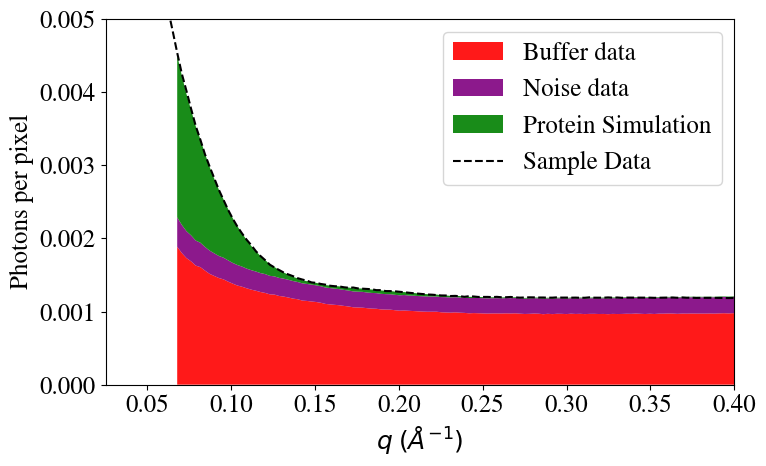

In [11]:
# Stack plot
plt.figure(4,figsize=(8,5))

plt.stackplot(rad, -buff * opt_params[0],
              -gasn * opt_params[1], 
              #-gasProfile*opt_params[2], 
              #-opt_params[3]+gasProfile*0, 
              -opt_params[4]*simSAXS, 
              labels=['Buffer data', 'Noise data', 'Protein Simulation'], 
              colors=['red', 'purple', 'green'], alpha=0.9)
'''
plt.stackplot(rad, -buffer.sampleSAXS * opt_params[0]-0*(gasnoz.sampleSAXS * opt_params[1]+gasProfile*opt_params[2]+opt_params[3]),
              -gasnoz.sampleSAXS * opt_params[1], 
              -gasProfile*opt_params[2], 
              -opt_params[3]+gasProfile*0, 
              -opt_params[4]*simSAXS, 
              labels=['Buffer data', 'Nozzle + Gas data', 'Gas Simulation', 'Const', 'Protien Simulation'], 
              colors=['red', 'purple', 'orange','cyan','green'], alpha=0.9)
'''
plt.plot(rad, samp,'k--', label='Sample Data')
plt.legend()
plt.xlim([.25e9,4.0e9])
def format_func(value, tick_number):
    return f"{value * 1e-10:.2f}"  # multiply the value by the constant and format it to two decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel(r'$q$ $\left(Å^{-1}\right)$')
plt.ylabel(r'Photons per pixel')
plt.gca().set_yscale('linear')
plt.ylim([0e-3,.5e-2])
#plt.title('Sample data SAXS decomposition')
plt.tight_layout()
#plt.savefig('dist.png', format='png', transparent=False)
plt.savefig('results/stacked.pdf', format='pdf')
plt.show()


DF 100 Chi2 of SAXS 1.0846205174252561 pval 1.0
Looking up unique atomic volumes...

                Voxel size is greater than 1 A. This may lead to less accurate I(q) estimates at high q.

                To avoid long computation times and excessive memory requirements, the number of voxels
                has been limited to 256 and the voxel size has been set to 1.00,
                which may be too large and lead to less accurate I(q) estimates at high q.

                To ensure the highest accuracy, manually set the -s option to 257.11 and
                the -v option to 1.00, which will set -n option to 258 and thus 
                may take a long time to calculate and use a lot of memory.
                If that requires too much computation, set -s first, and -n to the 
                limit you prefer (n=512 may approach an upper limit for many computers).
                
Calculating in vacuo density...
Finished in vacuo density.
Calculating excluded volume...
Finishe

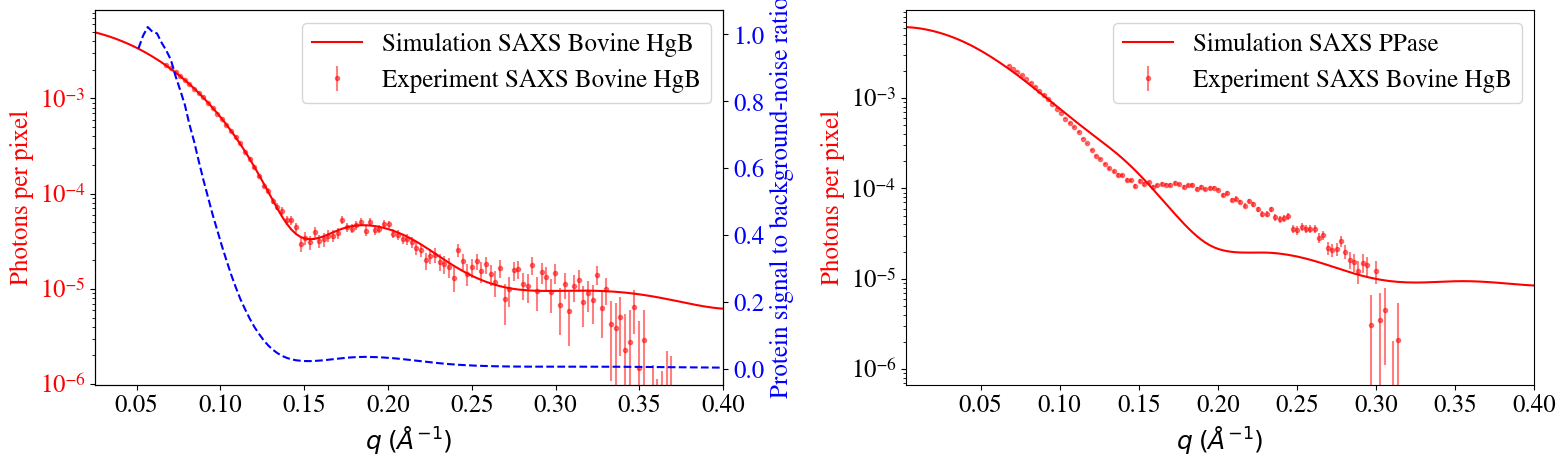

In [12]:
# Assuming rad, opt_params, simSAXS, and sample.sampleSAXS are already defined
signalRatio = -opt_params[4] * simSAXS / (samp +opt_params[4] * simSAXS)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 5))
# Create a second y-axis
ax2 = ax1.twinx()

# Plot the first curve
ax2.plot(rad, signalRatio, '--',label='Signal Ratio', color='b')
ax2.set_xlabel(r'$q$ $\left(Å^{-1}\right)$')
ax2.set_ylabel('Protein signal to background-noise ratio', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Format the x-axis
def format_func(value, tick_number):
    return f"{value * 1e-10:.2f}"  # multiply the value by the constant and format it to two decimal places

ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlim([.25e9,4.0e9])

ax1.plot(rad, -opt_params[4] * simSAXS,'-', label='Simulation SAXS Bovine HgB', color='r')
ax1.errorbar(rad, output, error, label='Experiment SAXS Bovine HgB', alpha=0.5, marker='.', linestyle='None', capsize=0, color='r')
ax1.set_xlabel(r'$q$ $\left(Å^{-1}\right)$')
ax1.set_ylabel('Photons per pixel', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_yscale('log')
ax1.legend()

fig.tight_layout()  # Adjust layout to prevent label overlap
######  ERROR STATS CHI2 ############################
radialmask = ~np.isnan(output) & (rad > window[0]) & (rad < window[1])
Iq_exp = np.concatenate((rad[radialmask, np.newaxis], output[radialmask, np.newaxis], error[radialmask, np.newaxis]),axis=1)
Iq_calc = np.concatenate((rad[radialmask, np.newaxis], -opt_params[4] * simSAXS[radialmask, np.newaxis]),axis=1)
chi2 = denss.saxstats.calc_chi2(Iq_exp,Iq_calc)
PVAL = 1-stats.chi2.pdf(chi2 , 100)
print("DF",len(rad[radialmask]), "Chi2 of SAXS", chi2,"pval",PVAL)
#####################################################################
#plt.savefig('ratio.png', format='png', transparent=False)
#plt.savefig('ratio.pdf', format='pdf')

# Load the .mat files
q_bins, simSAXS2 = denss.get_scattering_profile(
    pdb_file="117e.pdb",
    create_bio_assembly=True,
    q_mags=rad,
    ignore_waters=False
)
simSAXS2*=1.0/400*scale
# Minimization
window = [.75e9, 3.5e9]
conds = (rcenter > window[0]) & (rcenter < window[1])
#initial_guess = [0.5661,   0.0001,   1, 0.1, 0.8713]
initial_guess = [1,   1,   1, 1, 1]

def objective(x): 
    return np.mean((samp[conds] + buff[conds] * x[0] + gasn[conds]*x[1] + gasProfile[conds]*x[2] + x[3] + x[4] * simSAXS2[conds]) ** 2)
#                                                                                             buffer     gas     gas-sim  const  protien-sim
opt_params = minimize(objective, initial_guess,  method='Trust-constr', tol=1e-26, bounds=[(None, 0), (None, 0), (0, 0), (0, 0), (None, 0)])
opt_params = opt_params.x

print(opt_params)
output = samp + buff * opt_params[0] + gasn * opt_params[1] + gasProfile*opt_params[2] + opt_params[3]
error = samp_e + buff_e * np.abs(opt_params[0]) + gasn_e * np.abs(opt_params[1])

#plt.figure(3, figsize=(8,5))
ax3.errorbar(rad, output, error, label='Experiment SAXS Bovine HgB', alpha=0.5, marker='.', linestyle='None', capsize=0, color='r') 
ax3.semilogy(rad, -opt_params[4] * simSAXS2, label='Simulation SAXS PPase',color='r')
#plt.stem(window,[.01,.01],label='minsearch x-limits', linefmt='g', markerfmt='go', basefmt='g-')
ax3.set_xlim([.025e9,4.0e9])
def format_func(value, tick_number):
    return f"{value * 1e-10:.2f}"  
ax3.xaxis.set_major_formatter(FuncFormatter(format_func))
ax3.set_xlabel(r'$q$ $\left(Å^{-1}\right)$')
ax3.set_ylabel(r'Photons per pixel', color='r')
ax3.legend()
plt.tight_layout()
plt.savefig('results/testSAXS.pdf', format='pdf')

######  ERROR STATS CHI2 ############################
radialmask = ~np.isnan(output) & (rad > window[0]) & (rad < window[1])
Iq_exp = np.concatenate((rad[radialmask, np.newaxis], output[radialmask, np.newaxis], error[radialmask, np.newaxis]),axis=1)
Iq_calc = np.concatenate((rad[radialmask, np.newaxis], -opt_params[4] * simSAXS2[radialmask, np.newaxis]),axis=1)
chi2 = denss.saxstats.calc_chi2(Iq_exp,Iq_calc)
PVAL = 1-stats.chi2.pdf(chi2 , 100)
print("DF",len(rad[radialmask]), "Chi2 of SAXS", chi2,"pval",PVAL)
#####################################################################
